# **FTP-Based GMS IR DATA VIEWER**





---

(For questions: Contact me @sohum09#4282 on Discord)

In [5]:
#Important: Download 'cmap_collections.py' and upload to this colab notebook before starting.
#Link to file: https://github.com/Sohum09/Code-for-storms/blob/main/cmap_collection.py

#Input the relevant data you want...

satellite = 'GMS5' #GMS1, GMS2, GMS3, GMS4, GMS5
hour = '09' #In UTC
date = '09/06/1997' #DD/MM/YYYY
lat, lon = 15.8, 149.1 #North, East; make latitude -ve for South, longitude -ve for West

#Specify colour table here:
import cmap_collection as cc
col, vmax, vmin = cc.fozbd2() #Input color table here in the format cc.<name_of_color_table_function>

#------------------------------------------------------------------------------------#
#-----Don't touch anything below from here (unless you know your way around code)----#
#------------------------------------------------------------------------------------#

lon = (lon + 360) % 360 #Rounds 160-180W to 180-200E to be compatible for use in GMS data files...

import subprocess, sys, datetime, requests
packages = ["cartopy"]
for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

#Processing, downloading and extracting relevant files...
from ftplib import FTP

date_array = date.split('/')
year = date_array[2]
month = date_array[1]
day = date_array[0]

ftp = FTP('gms.cr.chiba-u.ac.jp')
ftp.login()
print("Connected to FTP server successfully!")

if satellite.upper() == 'GMS5':
  ftp.cwd(f'/pub/{satellite.upper()}/RVISSR/{str(year)}{str(int(month)).zfill(2)}/')
  print("Changed directory succesfully.")

  local_filename = f'{str(year)}{str(int(month)).zfill(2)}{str(int(day)).zfill(2)}{str(int(hour)).zfill(2)}00.tar.gz'
  remote_filename = f'{str(year)}{str(int(month)).zfill(2)}{str(int(day)).zfill(2)}{str(int(hour)).zfill(2)}00.tar.gz'

  with open(local_filename, 'wb') as file:
    ftp.retrbinary(f'RETR {remote_filename}', file.write)

  print(f"File '{local_filename}' downloaded successfully!")

  ftp.quit()

  import tarfile
  import os

  if os.path.exists(local_filename):
    with tarfile.open(local_filename, 'r:gz') as tar:
      tar.extractall()
  print(f"File '{local_filename}' extracted successfully!")

  import glob
  import pandas as pd

  relevant_files = []
  relevant_files.extend(glob.glob('/content/ir1_tbl*.csv'))
  relevant_files.extend(glob.glob('/content/ir1_count*.raw'))

  table = pd.read_csv(relevant_files[0])
  file_path = relevant_files[1]

  import numpy as np

  file_path = '/content/ir1_count_19970609_0831.raw'
  image_width = 2400
  image_height = 2400
  dtype = np.uint8

  with open(file_path, 'rb') as f:
      raw_data = f.read()

  decoded_data = np.frombuffer(raw_data, dtype=dtype).reshape((image_height, image_width))

  print("Decoded data shape:", decoded_data.shape)
  print("Decoded data type:", decoded_data.dtype)

  # Create a mapping from raw values to calibrated values from the table
  calibration_map = table.set_index(table.columns[0])[table.columns[1]]

  # Apply the calibration mapping to the decoded data
  calibrated_data = np.vectorize(calibration_map.get)(decoded_data)

  print("Calibrated data shape:", calibrated_data.shape)
  print("Calibrated data type:", calibrated_data.dtype)

else:
  ftp.cwd(f'/pub/{satellite.upper()}/gridded/{str(year)}{str(int(month)).zfill(2)}')
  print("Changed directory succesfully.")

  local_filename = f"IR{str(year)[-2:]}{str(int(month)).zfill(2)}{str(int(day)).zfill(2)}.Z{str(int(hour)).zfill(2)}.tar.bz2"
  remote_filename = f"IR{str(year)[-2:]}{str(int(month)).zfill(2)}{str(int(day)).zfill(2)}.Z{str(int(hour)).zfill(2)}.tar.bz2"

  with open(local_filename, 'wb') as file:
      ftp.retrbinary(f'RETR {remote_filename}', file.write)

  print(f"File '{local_filename}' downloaded successfully!")

  ftp.quit()

  import tarfile
  import os

  if os.path.exists(local_filename):
    with tarfile.open(local_filename, 'r:bz2') as tar:
      tar.extractall()
  print(f"File '{local_filename}' extracted successfully!")

Connected to FTP server successfully!
Changed directory succesfully.
File '199706090900.tar.gz' downloaded successfully!


/tmp/ipython-input-3386105262.py:57: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


File '199706090900.tar.gz' extracted successfully!
Decoded data shape: (2400, 2400)
Decoded data type: uint8
Calibrated data shape: (2400, 2400)
Calibrated data type: float64


Creating the plot...


/usr/local/lib/python3.12/dist-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


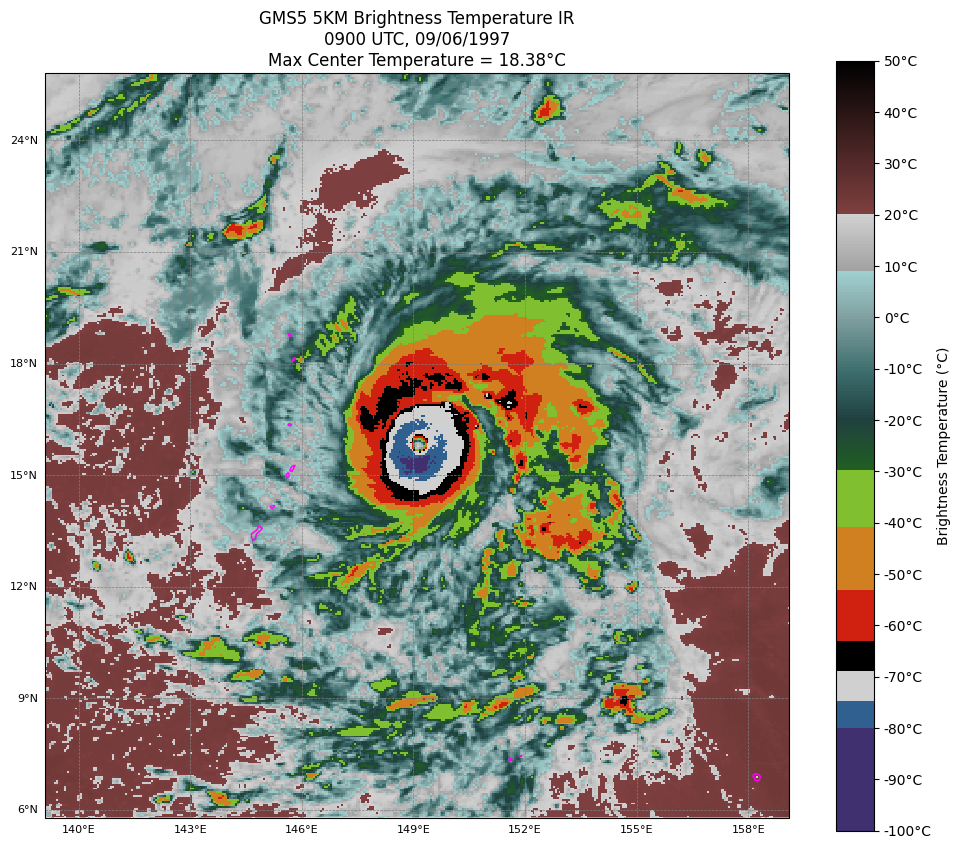

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

if satellite.upper() != 'GMS5':
  # --- 1. File and data specifications ---
  file_path = f'/content/IR{str(year)[-2:]}{str(int(month)).zfill(2)}{str(int(day)).zfill(2)}.Z{str(int(hour)).zfill(2)}.geoss'
  data_shape = (3000, 3000)
  data_type = np.float32

  lat_bounds = (60, -60)
  lon_bounds = (80, 200)

  error_correction = 0

  if satellite.upper() == 'GMS2':
      error_correction = 3.5
  elif satellite.upper() == 'GMS3':
      error_correction = 4.75
  elif satellite.upper() == 'GMS4':
      error_correction = 3.5
  else:
      error_correction = 3.5

  # --- 2. Decode the binary file with NumPy ---
  try:
      with open(file_path, 'rb') as f:
          data_array = np.fromfile(f, dtype=data_type)

      decoded_geoss = data_array.reshape(data_shape)
      print(f"Successfully decoded and reshaped data to {decoded_geoss.shape}.")

  except FileNotFoundError:
      print(f"Error: The file '{file_path}' was not found.")
      exit()
  except ValueError as e:
      print(f"Error during reshape: {e}")
      print("The file size might not correspond to the expected 3000x3000 float32 array.")
      exit()

  # --- 3. Generate coordinate arrays for plotting ---
  latitudes = np.linspace(lat_bounds[0], lat_bounds[1], data_shape[0])
  longitudes = np.linspace(lon_bounds[0], lon_bounds[1], data_shape[1])

  # --- 4. Plot the data as a geographical map + find center temp ---
  print("Creating the plot...")
  fig = plt.figure(figsize=(12, 10))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.add_feature(cfeature.COASTLINE, linewidth=1, color='magenta')

  gls = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
  gls.xlocator = mticker.FixedLocator(range(80, 201, 3))  # Control gridline spacing
  gls.ylocator = mticker.FixedLocator(range(-60, 61, 3))
  #gls.xformatter = LONGITUDE_FORMATTER
  gls.yformatter = LATITUDE_FORMATTER
  gls.xlabel_style = {'size': 8, 'color': 'k'}  # Customize label style
  gls.ylabel_style = {'size': 8, 'color': 'k'}
  gls.top_labels = False
  gls.right_labels = False

  mesh = ax.pcolormesh(longitudes, latitudes, decoded_geoss+error_correction, cmap=col, vmax=vmax, vmin=vmin)

  cbar = fig.colorbar(mesh, ax=ax)
  # Set custom ticks in Celsius with intervals of 10°C
  celsius_tick_values = np.arange(-100, 60, 10)  # Adjust the range if needed
  kelvin_tick_values = celsius_tick_values + 273.15  # Convert Celsius ticks to Kelvin

  # Update the colorbar ticks and labels
  cbar.set_ticks(kelvin_tick_values)  # Set the ticks in Kelvin
  cbar.set_ticklabels([f"{int(temp)}°C" for temp in celsius_tick_values])  # Label them in Celsius
  cbar.set_label('Brightness Temperature (°C)')

  # Finding center temperature...
  # Find the indices corresponding to the specified lat, lon and a 1-degree radius
  lat_index = np.abs(latitudes - lat).argmin()
  lon_index = np.abs(longitudes - lon).argmin()

  # Calculate the range of indices within 1 degree
  lat_degree_span = np.abs(latitudes[1] - latitudes[0])
  lon_degree_span = np.abs(longitudes[1] - longitudes[0])

  lat_radius_indices = int(1 / lat_degree_span)
  lon_radius_indices = int(1 / lon_degree_span)

  # Ensure the indices are within the bounds of the array
  min_lat_index = max(0, lat_index - lat_radius_indices)
  max_lat_index = min(data_shape[0], lat_index + lat_radius_indices + 1)
  min_lon_index = max(0, lon_index - lon_radius_indices)
  max_lon_index = min(data_shape[1], lon_index + lon_radius_indices + 1)

  # Extract the subset of data
  data_subset = decoded_geoss[min_lat_index:max_lat_index, min_lon_index:max_lon_index]

  # Find the maximum value in the subset and correct it for calibration
  max_value = np.max(data_subset)
  max_value_celcius_calibration_corrected = max_value + error_correction - 273.15

  ax.set_title(f'{satellite.upper()} 5KM Brightness Temperature IR\n{str(int(hour)).zfill(2)}00 UTC, {str(int(day)).zfill(2)}/{str(int(month)).zfill(2)}/{year}\nMax Center Temperature = {max_value_celcius_calibration_corrected:.02f}°C')
  ax.grid(True, linestyle='--', alpha=0.6)

  ax.set_xlim(lon-10, lon+10)
  ax.set_ylim(lat-10, lat+10)

  plt.show()

  import glob
  import os

  files_to_remove = []
  files_to_remove.extend(glob.glob('/content/*.tar.bz2'))
  files_to_remove.extend(glob.glob('/content/*.geoss'))
  files_to_remove.extend(glob.glob('/content/*.txt'))

  for f in files_to_remove:
      os.remove(f)
else:
  data_shape = (2400, 2400)
  data_type = np.uint8

  lat_bounds = (60, -60)
  lon_bounds = (80, 200)

  # Generate coordinate arrays for plotting ---
  latitudes = np.linspace(lat_bounds[0], lat_bounds[1], data_shape[0])
  longitudes = np.linspace(lon_bounds[0], lon_bounds[1], data_shape[1])

  # --- 4. Plot the data as a geographical map + find center temp ---
  print("Creating the plot...")
  fig = plt.figure(figsize=(12, 10))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.add_feature(cfeature.COASTLINE, linewidth=1, color='magenta')

  gls = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
  gls.xlocator = mticker.FixedLocator(range(80, 201, 3))  # Control gridline spacing
  gls.ylocator = mticker.FixedLocator(range(-60, 61, 3))
  #gls.xformatter = LONGITUDE_FORMATTER
  gls.yformatter = LATITUDE_FORMATTER
  gls.xlabel_style = {'size': 8, 'color': 'k'}  # Customize label style
  gls.ylabel_style = {'size': 8, 'color': 'k'}
  gls.top_labels = False
  gls.right_labels = False

  mesh = ax.pcolormesh(longitudes, latitudes, calibrated_data, cmap=col, vmax=vmax, vmin=vmin)

  cbar = fig.colorbar(mesh, ax=ax)
  # Set custom ticks in Celsius with intervals of 10°C
  celsius_tick_values = np.arange(-100, 60, 10)  # Adjust the range if needed
  kelvin_tick_values = celsius_tick_values + 273.15  # Convert Celsius ticks to Kelvin

  # Update the colorbar ticks and labels
  cbar.set_ticks(kelvin_tick_values)  # Set the ticks in Kelvin
  cbar.set_ticklabels([f"{int(temp)}°C" for temp in celsius_tick_values])  # Label them in Celsius
  cbar.set_label('Brightness Temperature (°C)')

  # Finding center temperature...
  # Find the indices corresponding to the specified lat, lon and a 1-degree radius
  lat_index = np.abs(latitudes - lat).argmin()
  lon_index = np.abs(longitudes - lon).argmin()

  # Calculate the range of indices within 1 degree
  lat_degree_span = np.abs(latitudes[1] - latitudes[0])
  lon_degree_span = np.abs(longitudes[1] - longitudes[0])

  lat_radius_indices = int(1 / lat_degree_span)
  lon_radius_indices = int(1 / lon_degree_span)

  # Ensure the indices are within the bounds of the array
  min_lat_index = max(0, lat_index - lat_radius_indices)
  max_lat_index = min(data_shape[0], lat_index + lat_radius_indices + 1)
  min_lon_index = max(0, lon_index - lon_radius_indices)
  max_lon_index = min(data_shape[1], lon_index + lon_radius_indices + 1)

  # Extract the subset of data
  data_subset = calibrated_data[min_lat_index:max_lat_index, min_lon_index:max_lon_index]

  # Find the maximum value in the subset and correct it for calibration
  max_value = np.max(data_subset)
  max_value_celcius_calibration_corrected = max_value - 273.15

  ax.set_title(f'{satellite.upper()} 5KM Brightness Temperature IR\n{str(int(hour)).zfill(2)}00 UTC, {str(int(day)).zfill(2)}/{str(int(month)).zfill(2)}/{year}\nMax Center Temperature = {max_value_celcius_calibration_corrected:.02f}°C')
  ax.grid(True, linestyle='--', alpha=0.6)

  ax.set_xlim(lon-10, lon+10)
  ax.set_ylim(lat-10, lat+10)

  plt.show()

  import glob
  import os

  files_to_remove = []
  files_to_remove.extend(glob.glob('/content/*.tar.gz'))
  files_to_remove.extend(glob.glob('/content/*.raw'))
  files_to_remove.extend(glob.glob('/content/*.csv'))

  for f in files_to_remove:
      os.remove(f)